In [29]:
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from support import load_dataset
from tqdm import tqdm


In [30]:
#Load datasets
train_set, test_set = load_dataset()

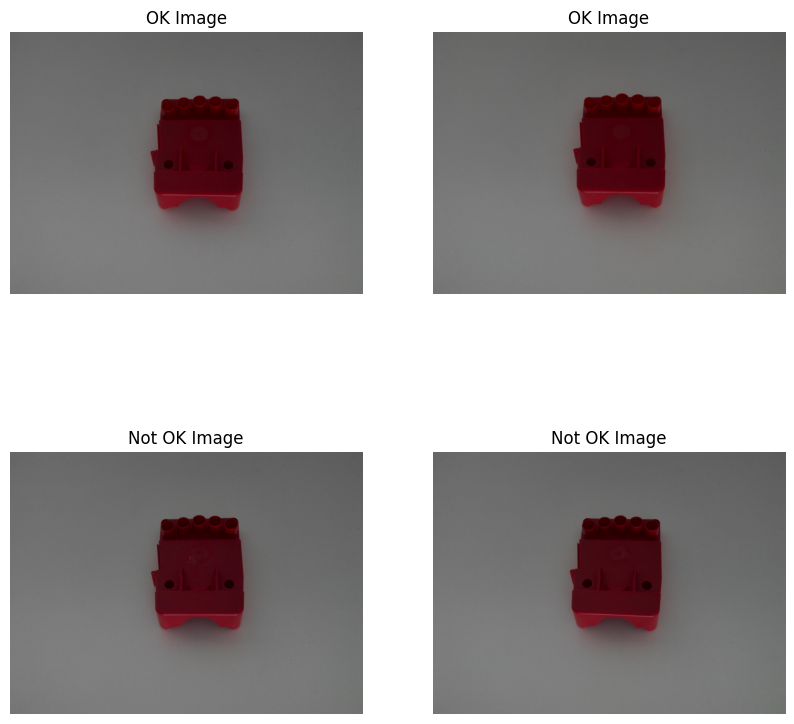

In [31]:
# Show two defective and non defective images
import os
import random

root = "WF-data/train/"
ok_images_path = root + "ok"
not_ok_images_path = root + "ng"

ok_images = os.listdir(ok_images_path)
not_ok_images = os.listdir(not_ok_images_path)


fig, ax = plt.subplots(2, 2, figsize=(10, 10))

#pick two random ok_images and show them

ok_images = random.sample(ok_images, 2)
not_ok_images = random.sample(not_ok_images, 2)

for i in range(2):
    image = plt.imread(root + "ok/" + ok_images[i])
    ax[0, i].imshow(image)
    ax[0, i].axis("off")
    ax[0, i].set_title("OK Image")

for i in range(2):
    image = plt.imread(root + "ng/" + not_ok_images[i])
    ax[1, i].imshow(image)
    ax[1, i].axis("off")
    ax[1, i].set_title("Not OK Image")
    


In [32]:
#Size of training and test sets
print(len(train_set))
print(len(test_set))
images = [image for image, label in train_set]

# concatenate all images into a single tensor
images = torch.stack(images)


136
34


In [33]:

# calculate mean and std for normalization for each channel
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

train_transform = transforms.Compose(
    [
        transforms.Resize([105, 78]),
        transforms.CenterCrop(size=[60, 30]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize([105, 78]),
        transforms.CenterCrop(size=[60, 30]),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

train_set.transform = train_transform
test_set.transform = test_transform



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
1


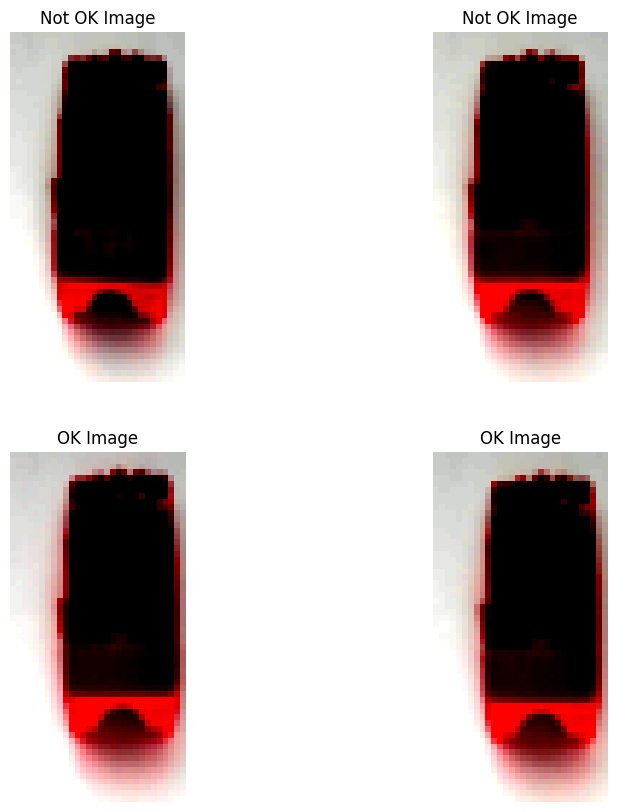

In [34]:
# show two ok images and two not ok images

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    # get random image
    n = random.randint(0, len(train_set)-100)
    image = train_set[n][0].permute(1,2,0)
    ax[0, i].imshow(image)
    ax[0, i].axis("off")
    ax[0, i].set_title("Not OK Image")
    print(train_set[n][1])

for i in range(2):
    n = random.randint(100, len(train_set)-1)
    image = train_set[i + 100][0].permute(1,2,0)
    ax[1, i].imshow(image)
    ax[1, i].axis("off")
    ax[1, i].set_title("OK Image")  
    print(train_set[n][1])

In [35]:
# split the training set into training and validation sets
train_set, val_set = torch.utils.data.random_split(train_set, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


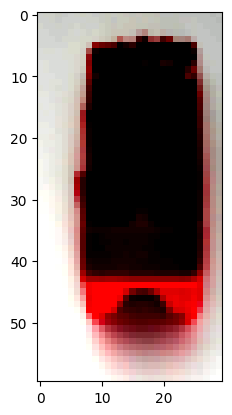

In [36]:
plt.imshow(train_set[90][0].permute(1,2,0), cmap='gray')
print(train_set[90][1])

In [37]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.Dropout2d(0.1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Dropout2d(0.1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.Flatten())

        n_channels = self.feature_extractor(torch.empty(1, 3, 60, 30)).size(-1)

        self.classifier = nn.Sequential(
            nn.Linear(n_channels, 64),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        classification = self.classifier(features)
        return(classification)

In [38]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

In [39]:
# Define model, loss function, optimizer and other parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [40]:
def test(model, dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            predicted = torch.argmax(outputs, dim = 1)
            correct += (predicted == labels).sum().item()
            total_samples += len(labels)
    test_acc = correct/total_samples
    test_loss /= len(dataloader)
    #print(f'Test accuracy: {100.0 * test_acc :.3f}% || Test loss: {test_loss :.3f}')
    return test_acc, test_loss

In [41]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [42]:
from torchinfo import summary

summary(model, input_size=(1, 3, 60, 30))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifier                          [1, 2]                    --
├─Sequential: 1-1                        [1, 12800]                --
│    └─Conv2d: 2-1                       [1, 16, 60, 30]           448
│    └─Dropout2d: 2-2                    [1, 16, 60, 30]           --
│    └─ReLU: 2-3                         [1, 16, 60, 30]           --
│    └─Conv2d: 2-4                       [1, 32, 60, 30]           4,640
│    └─Dropout2d: 2-5                    [1, 32, 60, 30]           --
│    └─ReLU: 2-6                         [1, 32, 60, 30]           --
│    └─Conv2d: 2-7                       [1, 64, 60, 30]           18,496
│    └─ReLU: 2-8                         [1, 64, 60, 30]           --
│    └─MaxPool2d: 2-9                    [1, 64, 20, 10]           --
│    └─Flatten: 2-10                     [1, 12800]                --
├─Sequential: 1-2                        [1, 2]                    --
│    └─

In [43]:
# Train the model
num_epochs = 40

val_accs = []
val_losses = []
train_accs = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    
    average_train_loss = 0
    average_correct = 0
    trained_samples = 0
    train_acc = 0


    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, labels) in pbar:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # Zero out the gradients for initialisation
        outputs = model(images) # Compute output
        # Reshape targets to match the output shape
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Perform backpropagation step
        optimizer.step() # Update the weights

        average_train_loss+=(loss.item() - average_train_loss )/(i + 1)
        predicted = torch.argmax(outputs, dim = 1)
        
        correct = (predicted == labels).sum().item()
        train_acc+=correct

        trained_samples += len(labels)
        average_correct = train_acc/trained_samples
    
    
        pbar.set_description(f'Epoch: {epoch+1}')
        pbar.set_postfix(loss = average_train_loss, accuracy = 100.0 * average_correct)

    test_acc, test_loss = test(model, val_loader)
    val_accs.append(test_acc)
    val_losses.append(test_loss)
    train_accs.append(average_correct)
    train_losses.append(average_train_loss)

    print(f'Validation accuracy: {100.0 * test_acc :.3f}% || Validation loss: {test_loss :.3f}')

print('Finished training')

#pbar displays train accuracy along with loss accuracy. This can be seen in the lines of each Epoch


Epoch: 1: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it, accuracy=58.5, loss=2.22] 


Validation accuracy: 69.231% || Validation loss: 0.690


Epoch: 2: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it, accuracy=52, loss=0.689]  


Validation accuracy: 30.769% || Validation loss: 0.692


Epoch: 3: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it, accuracy=48.8, loss=0.7]  


Validation accuracy: 69.231% || Validation loss: 0.681


Epoch: 4: 100%|██████████| 8/8 [00:12<00:00,  1.53s/it, accuracy=47.2, loss=0.701]


Validation accuracy: 69.231% || Validation loss: 0.689


Epoch: 5: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it, accuracy=48.8, loss=0.694]


Validation accuracy: 69.231% || Validation loss: 0.691


Epoch: 6: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it, accuracy=48, loss=0.693]  


Validation accuracy: 69.231% || Validation loss: 0.693


Epoch: 7: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it, accuracy=53.7, loss=0.695]


Validation accuracy: 30.769% || Validation loss: 0.702


Epoch: 8: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it, accuracy=51.2, loss=0.693]


Validation accuracy: 30.769% || Validation loss: 0.704


Epoch: 9: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it, accuracy=52, loss=0.692]  


Validation accuracy: 30.769% || Validation loss: 0.707


Epoch: 10: 100%|██████████| 8/8 [00:12<00:00,  1.52s/it, accuracy=52, loss=0.692]  


Validation accuracy: 30.769% || Validation loss: 0.713


Epoch: 11: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it, accuracy=52, loss=0.691]  


Validation accuracy: 30.769% || Validation loss: 0.714


Epoch: 12: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it, accuracy=53.7, loss=0.691]


Validation accuracy: 30.769% || Validation loss: 0.712


Epoch: 13: 100%|██████████| 8/8 [00:12<00:00,  1.51s/it, accuracy=54.5, loss=0.691]


Validation accuracy: 30.769% || Validation loss: 0.718


Epoch: 14: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it, accuracy=54.5, loss=0.688]


Validation accuracy: 30.769% || Validation loss: 0.725


Epoch: 15: 100%|██████████| 8/8 [00:12<00:00,  1.54s/it, accuracy=52.8, loss=0.696]


Validation accuracy: 30.769% || Validation loss: 0.722


Epoch: 16: 100%|██████████| 8/8 [00:12<00:00,  1.53s/it, accuracy=53.7, loss=0.69] 


Validation accuracy: 30.769% || Validation loss: 0.717


Epoch: 17: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it, accuracy=54.5, loss=0.692]


Validation accuracy: 30.769% || Validation loss: 0.713


Epoch: 18: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it, accuracy=59.3, loss=0.663]


Validation accuracy: 38.462% || Validation loss: 0.700


Epoch: 19: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it, accuracy=66.7, loss=0.661]


Validation accuracy: 61.538% || Validation loss: 0.832


Epoch: 20: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it, accuracy=60.2, loss=0.813]


Validation accuracy: 61.538% || Validation loss: 0.688


Epoch: 21: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it, accuracy=74.8, loss=0.656]


Validation accuracy: 61.538% || Validation loss: 0.676


Epoch: 22: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it, accuracy=70.7, loss=0.612]


Validation accuracy: 61.538% || Validation loss: 0.657


Epoch: 23: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it, accuracy=76.4, loss=0.53] 


Validation accuracy: 53.846% || Validation loss: 0.735


Epoch: 24: 100%|██████████| 8/8 [00:12<00:00,  1.61s/it, accuracy=74.8, loss=0.51] 


Validation accuracy: 61.538% || Validation loss: 0.974


Epoch: 25: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it, accuracy=78, loss=0.579]  


Validation accuracy: 61.538% || Validation loss: 0.789


Epoch: 26: 100%|██████████| 8/8 [00:12<00:00,  1.62s/it, accuracy=77.2, loss=0.504]


Validation accuracy: 53.846% || Validation loss: 0.803


Epoch: 27: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it, accuracy=78.9, loss=0.505]


Validation accuracy: 61.538% || Validation loss: 0.871


Epoch: 28: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it, accuracy=78, loss=0.535]  


Validation accuracy: 61.538% || Validation loss: 0.682


Epoch: 29: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it, accuracy=77.2, loss=0.479]


Validation accuracy: 61.538% || Validation loss: 0.712


Epoch: 30: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it, accuracy=78.9, loss=0.497]


Validation accuracy: 61.538% || Validation loss: 0.833


Epoch: 31: 100%|██████████| 8/8 [00:13<00:00,  1.67s/it, accuracy=76.4, loss=0.492]


Validation accuracy: 61.538% || Validation loss: 0.999


Epoch: 32: 100%|██████████| 8/8 [00:13<00:00,  1.66s/it, accuracy=74.8, loss=0.522]


Validation accuracy: 61.538% || Validation loss: 0.735


Epoch: 33: 100%|██████████| 8/8 [00:14<00:00,  1.79s/it, accuracy=76.4, loss=0.57] 


Validation accuracy: 53.846% || Validation loss: 0.744


Epoch: 34: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it, accuracy=74.8, loss=0.534]


Validation accuracy: 53.846% || Validation loss: 0.734


Epoch: 35: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it, accuracy=75.6, loss=0.545]


Validation accuracy: 53.846% || Validation loss: 0.819


Epoch: 36: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it, accuracy=74.8, loss=0.517]


Validation accuracy: 46.154% || Validation loss: 0.699


Epoch: 37: 100%|██████████| 8/8 [00:12<00:00,  1.57s/it, accuracy=78, loss=0.485]  


Validation accuracy: 61.538% || Validation loss: 0.807


Epoch: 38: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it, accuracy=79.7, loss=0.494]


Validation accuracy: 61.538% || Validation loss: 0.838


Epoch: 39: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it, accuracy=77.2, loss=0.458]


Validation accuracy: 61.538% || Validation loss: 0.788


Epoch: 40: 100%|██████████| 8/8 [00:12<00:00,  1.55s/it, accuracy=82.1, loss=0.442]


Validation accuracy: 61.538% || Validation loss: 0.824
Finished training


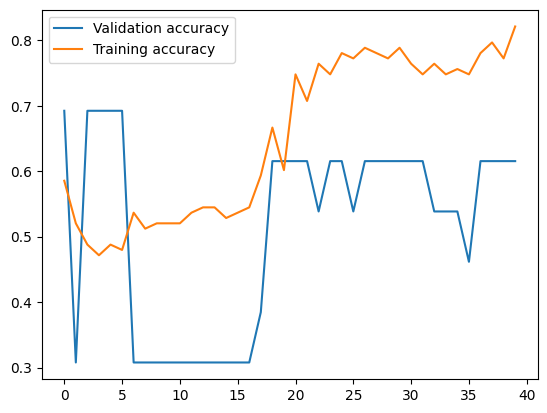

In [44]:
plt.plot(val_accs, label='Validation accuracy')
plt.plot(train_accs, label='Training accuracy')
plt.legend()

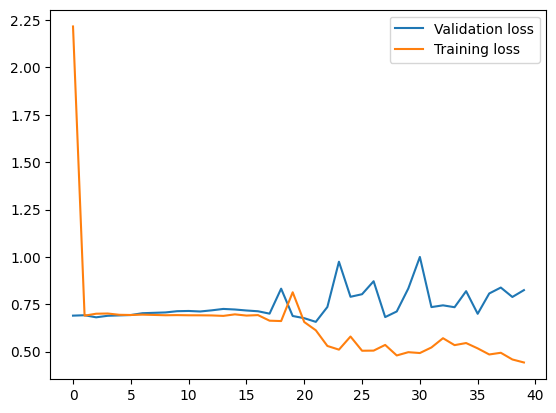

In [45]:
plt.plot(val_losses, label='Validation loss')
plt.plot(train_losses, label='Training loss')
plt.legend()

In [51]:
#parameters = torch.load('model2.pth')
#model.load_state_dict(parameters)


test(model, test_loader)
#test accuracy, test loss

(0.6176470588235294, 0.8517216245333353)

In [47]:
n = 100
image = train_set[n][0].unsqueeze(0).to(device)
output = model(image)
print(output)
print(train_set[n][1])

tensor([[-0.5001,  0.7084]], grad_fn=<AddmmBackward0>)
1


In [48]:
std

tensor([0.1650, 0.1717, 0.1729])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


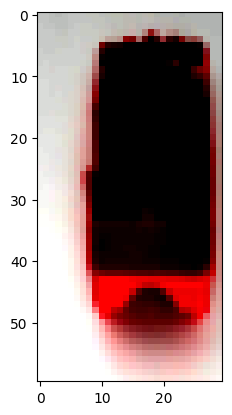

In [49]:
plt.imshow(test_set[33][0].permute(1,2,0), cmap='gray')

In [50]:
# torch.save(model.state_dict(), 'model2.pth')